In [70]:
import numpy as np
 
import matplotlib.pyplot as plt
import pandas as pd
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Hyper-parameters

In [71]:
n_epochs = 1000
batch_size = 32
learning_rate = 0.001
lamb = 0 # regularization constant
weight_decay = 0
momentum = 0

train_data_ratio = 0.8 # if 0.7 then train:test = 70:30 when randomly split it

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Data & Pre-processing

In [72]:
class Make_Dataset(Dataset):
 
  def __init__(self,x_tensor, y_tensor):
    self.x = x_tensor
    self.y = y_tensor
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

In [73]:
### Load Data ###

CCesc2i_Meta = pd.read_table('data/CellCycle/CCesc2i_Meta.txt')
CCesc2i_counts = pd.read_table('data/CellCycle/CCesc2i_counts.txt')
CCesc2i_sampleinfo = pd.read_table('data/CellCycle/CCesc2i_sampleinfo.txt')
CCescSerum_Meta = pd.read_table('data/CellCycle/CCescSerum_Meta.txt')
CCescSerum_counts = pd.read_table('data/CellCycle/CCescSerum_counts.txt')
CCescSerum_sampleinfo = pd.read_table('data/CellCycle/CCescSerum_sampleinfo.txt')

DTesc2i_Meta = pd.read_table('data/DrugTreatment/DTesc2i_Meta.txt')
DTesc2i_tpm = pd.read_table('data/DrugTreatment/DTesc2i_tpm.txt')
DTesc2i_sampleinfo = pd.read_table('data/DrugTreatment/DTesc2i_sampleinfo.txt')
DTescSerum_Meta = pd.read_table('data/DrugTreatment/DTescSerum_Meta.txt')
DTescSerum_tpm = pd.read_table('data/DrugTreatment/DTescSerum_tpm.txt')
DTescSerum_sampleinfo = pd.read_table('data/DrugTreatment/DTescSerum_sampleinfo.txt')

### re-arrange count matrix ###

CCesc2i_counts = CCesc2i_counts.set_index('Name').T.reset_index().rename(columns = {'index':'Name'})
CCesc2i_counts.columns.name = None
CCescSerum_counts = CCescSerum_counts.set_index('Name').T.reset_index().rename(columns = {'index':'Name'})
CCescSerum_counts.columns.name = None
DTesc2i_tpm = DTesc2i_tpm.set_index('Name').T.reset_index().rename(columns = {'index':'Name'})
DTesc2i_tpm.columns.name = None
DTescSerum_tpm = DTescSerum_tpm.set_index('Name').T.reset_index().rename(columns = {'index':'Name'})
DTescSerum_tpm.columns.name = None

### Inner Join three tables (Meta data, count matrix, sample info) ###

merged_CCesc2i = pd.merge(left=CCesc2i_Meta[['Counts_identifier','mVenus_A','mCherry_A','Hoechst_A']], right=CCesc2i_counts, left_on='Counts_identifier', right_on='Name')
merged_CCesc2i = pd.merge(left=CCesc2i_sampleinfo[['Unnamed: 0','percent_mapped']], right=merged_CCesc2i, left_on='Unnamed: 0', right_on='Counts_identifier')

merged_CCescSerum = pd.merge(left=CCescSerum_Meta[['Counts_identifier','mVenus_A','mCherry_A','Hoechst_A']], right=CCescSerum_counts, left_on='Counts_identifier', right_on='Name')
merged_CCescSerum = pd.merge(left=CCescSerum_sampleinfo[['Unnamed: 0','percent_mapped']], right=merged_CCescSerum, left_on='Unnamed: 0', right_on='Counts_identifier')

merged_DTesc2i = pd.merge(left=DTesc2i_Meta[['Counts_identifier','mVenus_A','mCherry_A','Hoechst_A']], right=DTesc2i_tpm, left_on='Counts_identifier', right_on='Name')
merged_DTesc2i = pd.merge(left=DTesc2i_sampleinfo[['Unnamed: 0','percent_mapped']], right=merged_DTesc2i, left_on='Unnamed: 0', right_on='Counts_identifier')

merged_DTescSerum = pd.merge(left=DTescSerum_Meta[['Counts_identifier','mVenus_A','mCherry_A','Hoechst_A']], right=DTescSerum_tpm, left_on='Counts_identifier', right_on='Name')
merged_DTescSerum = pd.merge(left=DTescSerum_sampleinfo[['Unnamed: 0','percent_mapped']], right=merged_DTescSerum, left_on='Unnamed: 0', right_on='Counts_identifier')

### process data ###

# Keep only percent_mapped > 40%
merged_CCesc2i = merged_CCesc2i.drop(merged_CCesc2i[merged_CCesc2i.percent_mapped <= 40].index)
merged_CCescSerum = merged_CCescSerum.drop(merged_CCescSerum[merged_CCescSerum.percent_mapped <= 40].index)
merged_DTesc2i = merged_DTesc2i.drop(merged_DTesc2i[merged_DTesc2i.percent_mapped <= 40].index)
merged_DTescSerum = merged_DTescSerum.drop(merged_DTescSerum[merged_DTescSerum.percent_mapped <= 40].index)

# Remove cell name "888"
# skip this action because couldn't find any cells contain name of '888'

# Remove cells with negative values in meta data
merged_CCesc2i = merged_CCesc2i.drop(merged_CCesc2i[merged_CCesc2i['mVenus_A'] < 0].index)
merged_CCesc2i = merged_CCesc2i.drop(merged_CCesc2i[merged_CCesc2i['mCherry_A'] < 0].index)
merged_CCesc2i = merged_CCesc2i.drop(merged_CCesc2i[merged_CCesc2i['Hoechst_A'] < 0].index)

merged_CCescSerum = merged_CCescSerum.drop(merged_CCescSerum[merged_CCescSerum['mVenus_A'] < 0].index)
merged_CCescSerum = merged_CCescSerum.drop(merged_CCescSerum[merged_CCescSerum['mCherry_A'] < 0].index)
merged_CCescSerum = merged_CCescSerum.drop(merged_CCescSerum[merged_CCescSerum['Hoechst_A'] < 0].index)

merged_DTesc2i = merged_DTesc2i.drop(merged_DTesc2i[merged_DTesc2i['mVenus_A'] < 0].index)
merged_DTesc2i = merged_DTesc2i.drop(merged_DTesc2i[merged_DTesc2i['mCherry_A'] < 0].index)
merged_DTesc2i = merged_DTesc2i.drop(merged_DTesc2i[merged_DTesc2i['Hoechst_A'] < 0].index)

merged_DTescSerum = merged_DTescSerum.drop(merged_DTescSerum[merged_DTescSerum['mVenus_A'] < 0].index)
merged_DTescSerum = merged_DTescSerum.drop(merged_DTescSerum[merged_DTescSerum['mCherry_A'] < 0].index)
merged_DTescSerum = merged_DTescSerum.drop(merged_DTescSerum[merged_DTescSerum['Hoechst_A'] < 0].index)

# further process: drop unused columns
CCesc2i = merged_CCesc2i.drop(columns=['percent_mapped', 'Counts_identifier', 'Name']).rename(columns = {'Unnamed: 0':'Name'})
CCescSerum = merged_CCescSerum.drop(columns=['percent_mapped', 'Counts_identifier', 'Name']).rename(columns = {'Unnamed: 0':'Name'})
DTesc2i = merged_DTesc2i.drop(columns=['percent_mapped', 'Counts_identifier', 'Name']).rename(columns = {'Unnamed: 0':'Name'})
DTescSerum = merged_DTescSerum.drop(columns=['percent_mapped', 'Counts_identifier', 'Name']).rename(columns = {'Unnamed: 0':'Name'})

# select UT condition from DT dataset
DTesc2i_UT = DTesc2i[DTesc2i["Name"].str.contains('UT')]
DTescSerum_UT = DTescSerum[DTescSerum["Name"].str.contains('UT')]

# Concat CC + DT_UT Data
CCesc2i_DTesc2i_UT = pd.concat([CCesc2i, DTesc2i_UT])
CCescSerum_DTescSerum_UT = pd.concat([CCescSerum, DTescSerum_UT])

# Concat all conditions
df_total = pd.concat([CCesc2i, CCescSerum, DTesc2i, DTescSerum])

In [74]:
# dataframe to numpy
np_features = CCesc2i_DTesc2i_UT.iloc[:, 4:].values
np_targets = CCesc2i_DTesc2i_UT.iloc[:, 1:4].values

# log normalization
np_features_diff = np_features - np.min(np_features, axis=0)
np_features = np.log(np_features + 0.001)

np_targets = np_targets - np.min(np_targets, axis=0)
np_targets = np.log(np_targets + 0.00001)

# data normalization
np_features = minmax_scaler.fit_transform(np_features)
np_targets = minmax_scaler.fit_transform(np_targets)

# dimensionality reduction by PCA & T-SNE

np_features = PCA(n_components=64).fit_transform(np_features)
#np_features = TSNE(n_components=64, init='random', method='exact').fit_transform(np_features)

# ex: D=50000 -> 500(pca) -> 30(t-sne)

distance_features = np.linalg.norm(np_features - np.mean(np_features, axis=0), axis=1)
distance_targets = np.linalg.norm(np_targets - np.mean(np_targets, axis=0), axis=1)

# remove outliers
index_feature_outliers = distance_features > np.min(distance_features) + 6*np.std(distance_features)
index_target_outliers = distance_targets > np.min(distance_targets) + 4*np.std(distance_targets)
index_outliers = np.logical_or(index_feature_outliers, index_target_outliers)
index = np.logical_not(index_outliers)
np_features = np_features[index]
np_targets = np_targets[index]

print(np.sum(index_feature_outliers))
print(np.sum(index_target_outliers))

cutoff_distance_features = np.linalg.norm(np_features - np.mean(np_features, axis=0), axis=1)
cutoff_distance_targets = np.linalg.norm(np_targets - np.mean(np_targets, axis=0), axis=1)

# data normalization
#np_features = minmax_scaler.fit_transform(np_features)
#np_targets = minmax_scaler.fit_transform(np_targets)

# convert to tensors
features = torch.tensor(np_features.astype(np.float32))
targets = torch.tensor(np_targets.astype(np.float32))

dataset = Make_Dataset(features, targets)
train_size = int(train_data_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

0
3


In [75]:
def plot_data_distribution(data, title=None):
    plt.figure(figsize=(25, 3))
    if title is not None:
        plt.title(title)
    plt.plot(data, 'o')
    plt.show()

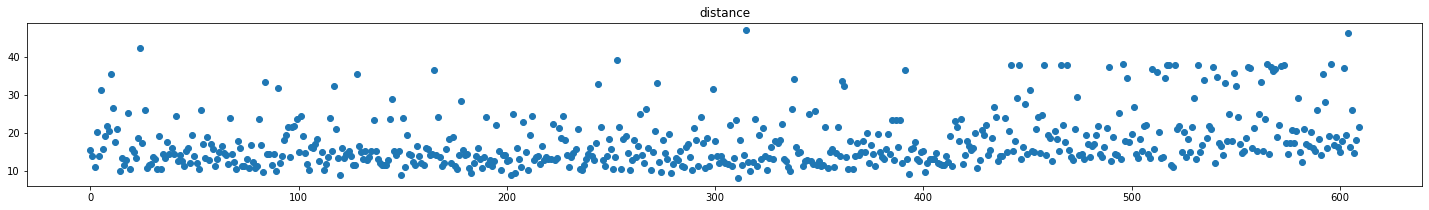

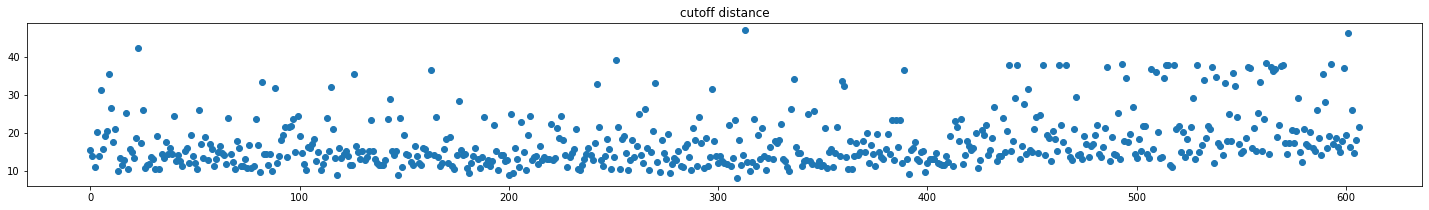

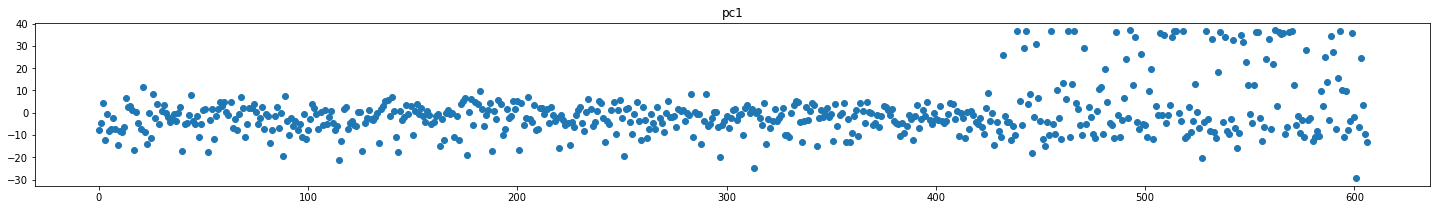

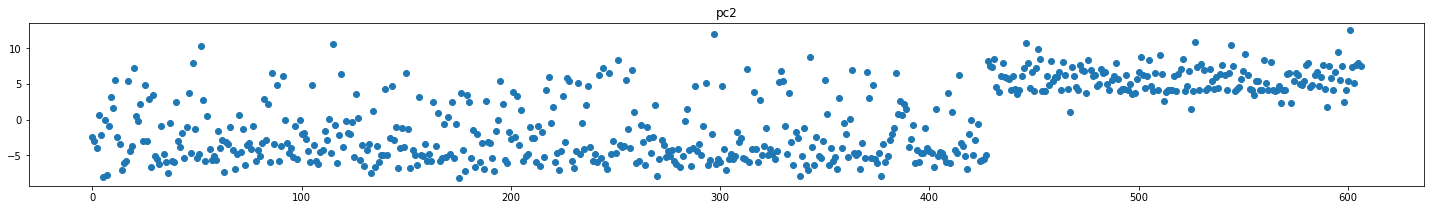

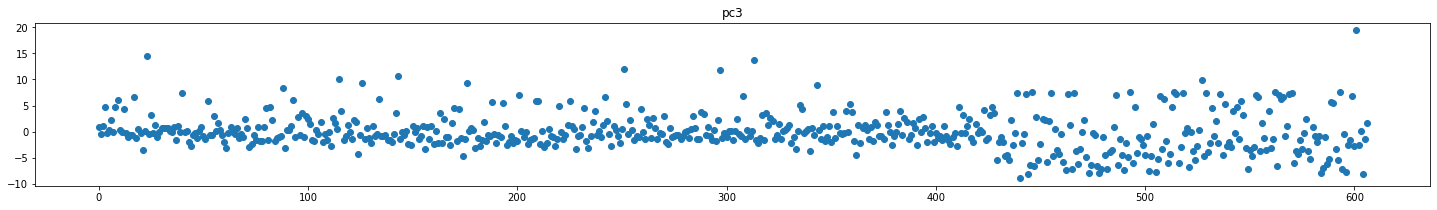

In [76]:
plot_data_distribution(distance_features, title='distance')
plot_data_distribution(cutoff_distance_features, title='cutoff distance')

for i in range(np_features.shape[1] if np_features.shape[1] < 3 else 3):
    plot_data_distribution(np_features[:, i], title='pc{}'.format(i+1))

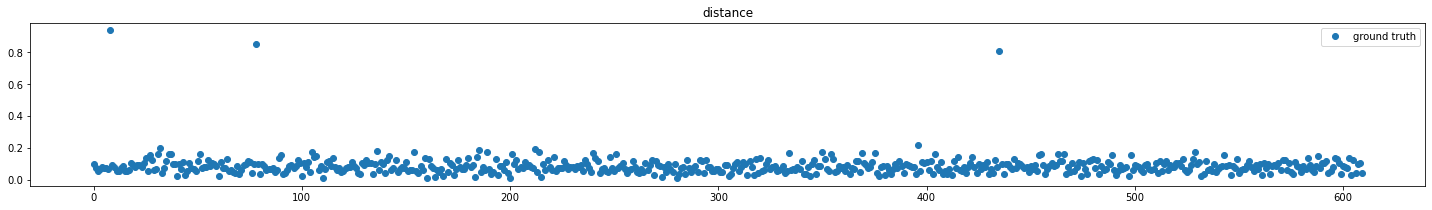

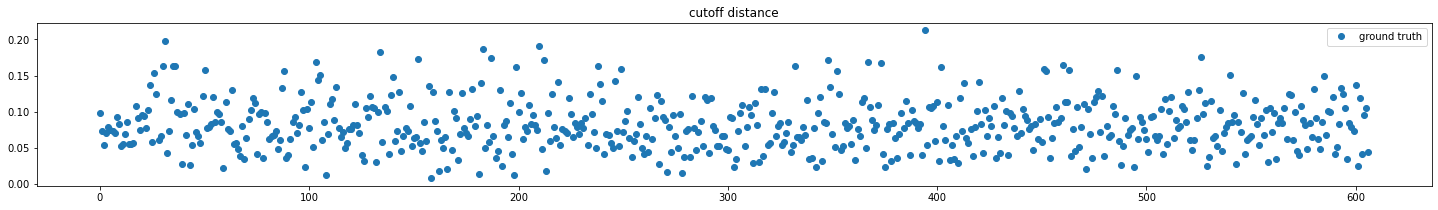

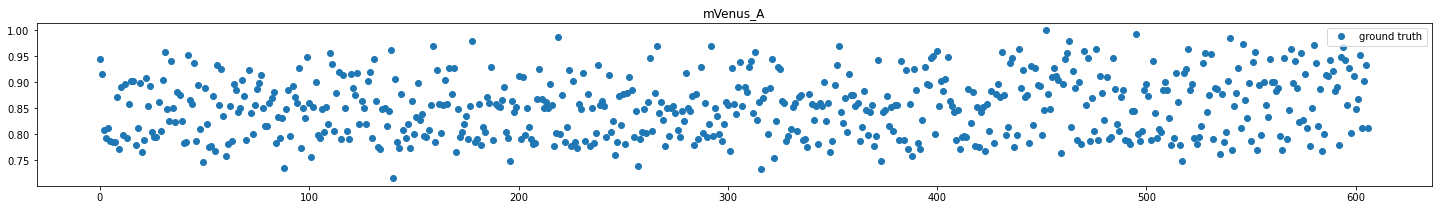

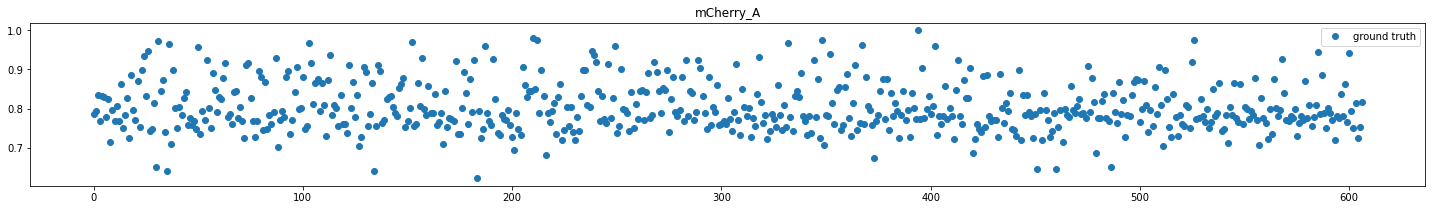

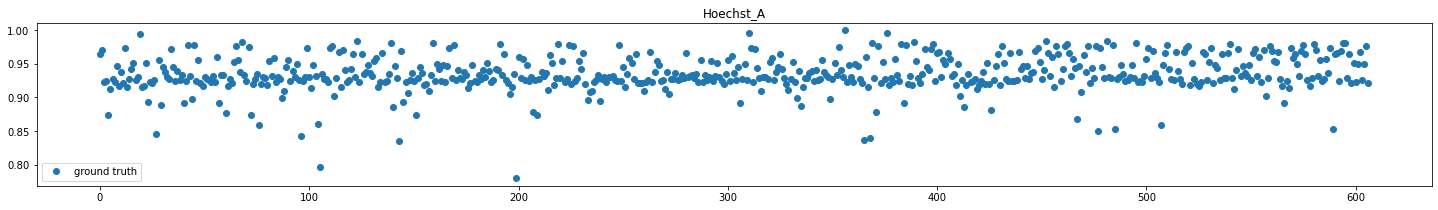

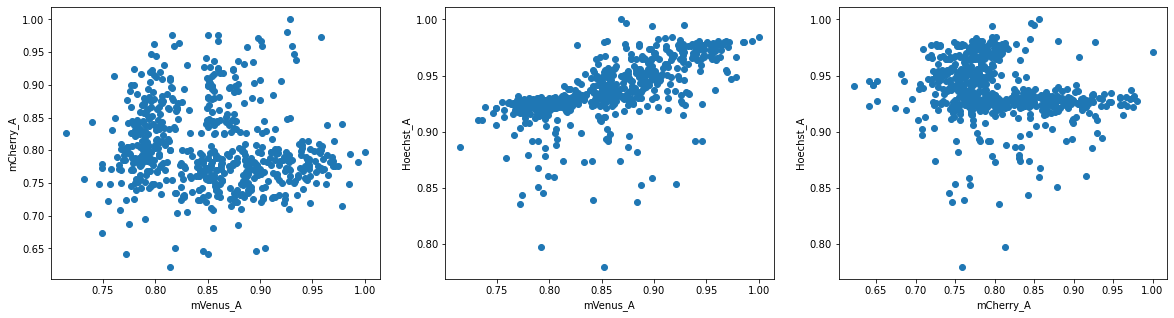

In [77]:
plt.figure(figsize=(25, 3))
plt.title('distance')
plt.plot(distance_targets, 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('cutoff distance')
plt.plot(cutoff_distance_targets, 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(np_targets[:, 0], 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(np_targets[:, 1], 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(np_targets[:, 2], 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(np_targets[:, 0], np_targets[:, 1])
plt.xlabel('mVenus_A')
plt.ylabel('mCherry_A')

plt.subplot(1, 3, 2)
plt.scatter(np_targets[:, 0], np_targets[:, 2])
plt.xlabel('mVenus_A')
plt.ylabel('Hoechst_A')

plt.subplot(1, 3, 3)
plt.scatter(np_targets[:, 1], np_targets[:, 2])
plt.xlabel('mCherry_A')
plt.ylabel('Hoechst_A')
plt.show()



In [78]:
print('CCesc2i_Meta size: {}'.format(CCesc2i_Meta.shape))
print('DTesc2i_Meta size: {}'.format(DTesc2i_Meta.shape))
print()
print('CCesc2i_counts size: {}'.format(CCesc2i_counts.shape))
print('DTesc2i_tpm size: {}'.format(DTesc2i_tpm.shape))
print()
print('merged_CCesc2i size: {}'.format(merged_CCesc2i.shape))
print('merged_DTesc2i size: {}'.format(merged_DTesc2i.shape))
print()
print('CCesc2i size: {}'.format(CCesc2i.shape))
print('DTesc2i size: {}'.format(DTesc2i.shape))
print()
print('DTesc2i_UT size: {}'.format(DTesc2i_UT.shape))
print()
print('CCesc2i_DTesc2i_UT size: {}'.format(CCesc2i_DTesc2i_UT.shape))
print('df_total size: {}'.format(df_total.shape))
print()
print('dataset size: {}'.format(len(dataset)))
print('train_dataset size: {}'.format(len(train_dataset)))
print('test_dataset size: {}'.format(len(test_dataset)))
print('feature_dim={} targets_dim={}'.format(features.shape[1], targets.shape[1]))
print()


CCesc2i_Meta size: (430, 30)
DTesc2i_Meta size: (541, 21)

CCesc2i_counts size: (485, 49194)
DTesc2i_tpm size: (581, 49194)

merged_CCesc2i size: (430, 49200)
merged_DTesc2i size: (536, 49200)

CCesc2i size: (430, 49197)
DTesc2i size: (536, 49197)

DTesc2i_UT size: (180, 49197)

CCesc2i_DTesc2i_UT size: (610, 49197)
df_total size: (1892, 49197)

dataset size: 607
train_dataset size: 485
test_dataset size: 122
feature_dim=64 targets_dim=3



# Define Network

In [79]:
class Network(nn.Module):

    def __init__(self, input_dim=30, output_dim=4):
        super(Network, self).__init__()

        n_layers = 5
        interval = (input_dim - output_dim) / n_layers

        self.linear1 = nn.Linear(input_dim, int(input_dim - interval))
        self.linear2 = nn.Linear(self.linear1.out_features, int(input_dim - 2*interval))
        self.linear3 = nn.Linear(self.linear2.out_features, int(input_dim - 3*interval))
        self.linear4 = nn.Linear(self.linear3.out_features, int(input_dim - 4*interval))
        self.linear5 = nn.Linear(self.linear4.out_features, output_dim)

        self.batch_norm1 = nn.BatchNorm1d(self.linear1.out_features)
        self.batch_norm2 = nn.BatchNorm1d(self.linear2.out_features)
        self.batch_norm3 = nn.BatchNorm1d(self.linear3.out_features)
        self.batch_norm4 = nn.BatchNorm1d(self.linear4.out_features)
        self.batch_norm5 = nn.BatchNorm1d(self.linear5.out_features)

        self.dropout_hidden = nn.Dropout(0)
        self.dropout_input = nn.Dropout(0)
        self.dropout_output = nn.Dropout(0)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

        pass

    def forward(self, x):
        y = self.dropout_input(x)
        y = self.linear1(y)
        y = self.leaky_relu(y)
        y = self.dropout_hidden(y)
        y = self.linear2(y)
        y = self.leaky_relu(y)
        y = self.dropout_hidden(y)
        y = self.linear3(y)
        y = self.leaky_relu(y)
        y = self.dropout_hidden(y)
        y = self.linear4(y)
        y = self.leaky_relu(y)
        y = self.dropout_hidden(y)
        y = self.linear5(y)
        y = self.sigmoid(y)
        y = self.dropout_output(y)

        return y

In [80]:
network = Network(input_dim=np_features.shape[1], output_dim=np_targets.shape[1]).to(device)
print(network)
print()

param_count = sum(p.numel() for p in network.parameters())
print('Number of Learnable Parameters: {}'.format(param_count))
print()

# data loader
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate / 100, max_lr=learning_rate,step_size_up=5,mode="triangular2")
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
optimizer = optim.Adam(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

train_losses = []
train_losses_std = []
test_losses = [] # regression loss of test data
test_losses_std = [] # regression loss of test data

best_model = copy.deepcopy(network)
lowest_test_loss = 99999

Network(
  (linear1): Linear(in_features=64, out_features=51, bias=True)
  (linear2): Linear(in_features=51, out_features=39, bias=True)
  (linear3): Linear(in_features=39, out_features=27, bias=True)
  (linear4): Linear(in_features=27, out_features=15, bias=True)
  (linear5): Linear(in_features=15, out_features=3, bias=True)
  (batch_norm1): BatchNorm1d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(39, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm4): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm5): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_hidden): Dropout(p=0, inplace=False)
  (dropout_input): Dropout(p=0, inplace=False)
  (dropout_output): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(ne

# Train

In [81]:
print('Train Start')

for epoch in range(n_epochs):

    network.train()

    train_losses_epoch = []
    test_losses_epoch = []

    for x, y in train_data_loader:

        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        pred = network(x)
        l1_norm = sum(p.abs().sum() for p in network.parameters())
        #l2_norm = sum(p.pow(2.0).sum() for p in network.parameters())
        loss = l1_loss(pred, y) + lamb * l1_norm
        loss.backward()
        optimizer.step()

        train_losses_epoch.append(loss.item())

    train_loss_epoch = np.mean(train_losses_epoch)
    train_loss_std_epoch = np.std(train_losses_epoch)
    train_losses.append(train_loss_epoch)
    train_losses_std.append(train_loss_std_epoch)

    ### test ###
    network.eval()
    for x, y in test_data_loader:

        x = x.to(device)
        y = y.to(device)
        pred = network(x)
        loss_reg = mse_loss(pred, y)
        test_losses_epoch.append(loss_reg.item())

    test_loss_epoch = np.mean(test_losses_epoch)
    test_loss_std_epoch = np.std(test_losses_epoch)
    test_losses.append(test_loss_epoch)
    test_losses_std.append(test_loss_std_epoch)

    if test_loss_epoch < lowest_test_loss:
        del best_model
        best_model = copy.deepcopy(network)
        lowest_test_loss = test_loss_epoch

    print('ecpoh: {}/{} train_loss: {:.6f} test_loss: {:6f}' \
        .format(epoch + 1, n_epochs, train_losses[epoch], test_losses[epoch]))

print('Train End')

Train Start
ecpoh: 1/1000 train_loss: 0.312204 test_loss: 0.084784
ecpoh: 2/1000 train_loss: 0.201671 test_loss: 0.026851
ecpoh: 3/1000 train_loss: 0.102575 test_loss: 0.009117
ecpoh: 4/1000 train_loss: 0.069524 test_loss: 0.005079
ecpoh: 5/1000 train_loss: 0.048778 test_loss: 0.003667
ecpoh: 6/1000 train_loss: 0.041865 test_loss: 0.003293
ecpoh: 7/1000 train_loss: 0.038746 test_loss: 0.003033
ecpoh: 8/1000 train_loss: 0.036814 test_loss: 0.002533
ecpoh: 9/1000 train_loss: 0.035953 test_loss: 0.002604
ecpoh: 10/1000 train_loss: 0.034398 test_loss: 0.002522
ecpoh: 11/1000 train_loss: 0.033143 test_loss: 0.002211
ecpoh: 12/1000 train_loss: 0.031729 test_loss: 0.002372
ecpoh: 13/1000 train_loss: 0.030265 test_loss: 0.002442
ecpoh: 14/1000 train_loss: 0.028668 test_loss: 0.002013
ecpoh: 15/1000 train_loss: 0.027050 test_loss: 0.001995
ecpoh: 16/1000 train_loss: 0.025586 test_loss: 0.001934
ecpoh: 17/1000 train_loss: 0.024597 test_loss: 0.002062
ecpoh: 18/1000 train_loss: 0.023553 test_loss

# Evaluation

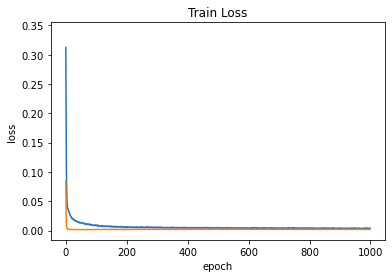

In [82]:
network.eval()
best_model.eval()

train_losses = np.array(train_losses)
train_losses_std = np.array(train_losses_std)
test_losses = np.array(test_losses)
test_losses_std = np.array(test_losses_std)

plt.plot(train_losses, '-')
plt.fill_between(range(len(train_losses)), train_losses-train_losses_std, train_losses+train_losses_std, facecolor='blue', alpha=0.3)
plt.plot(test_losses, '-', label='test loss')
plt.fill_between(range(len(test_losses)), test_losses-test_losses_std, test_losses+test_losses_std, facecolor='orange', alpha=0.3)
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

train loss=0.00010374406701885164


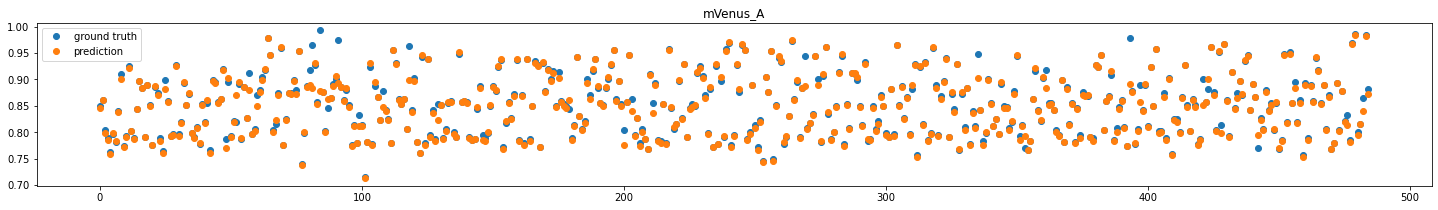

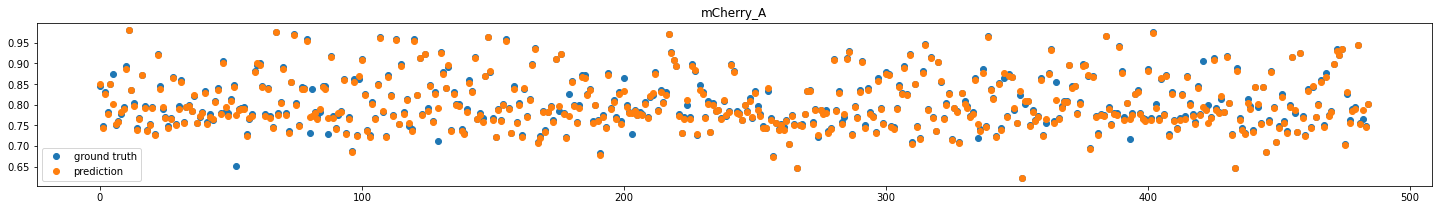

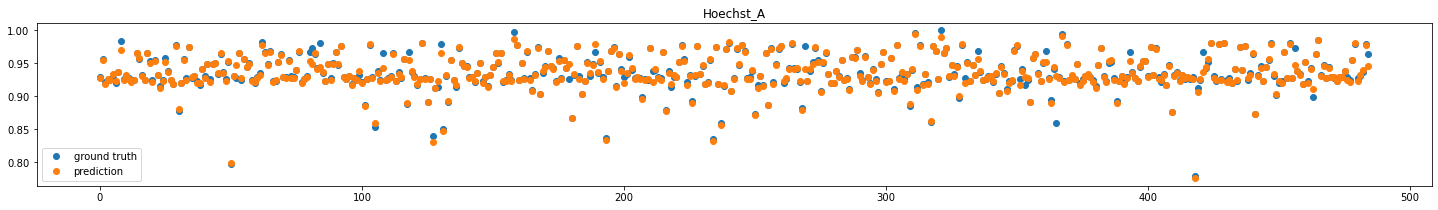

test loss=0.002145778387784958


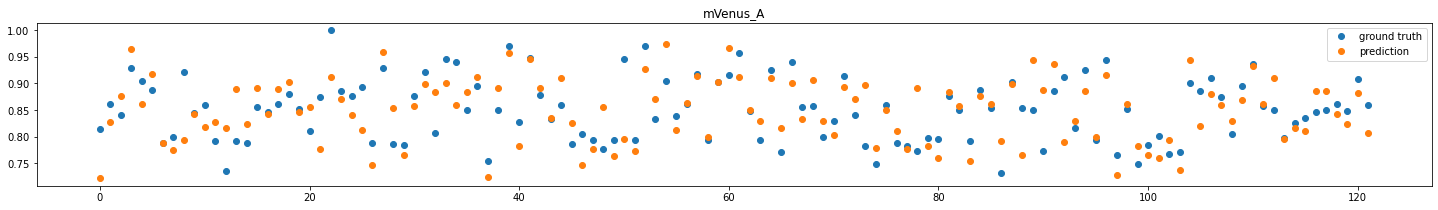

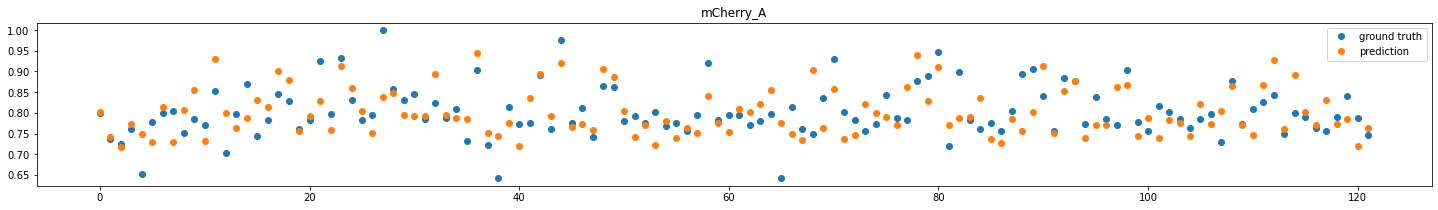

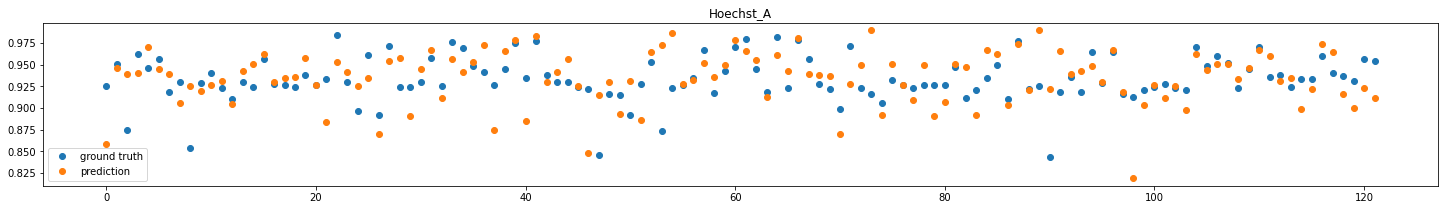

In [85]:
x, y = train_dataset[:]
x = x.to(device)
y = y.to(device)
pred = network(x)
y = y.cpu().detach()
pred = pred.cpu().detach()
train_loss = mse_loss(y, pred)

print('train loss={}'.format(train_loss.item()))

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(y[:, 0], 'o', label='ground truth')
plt.plot(pred[:, 0], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(y[:, 1], 'o', label='ground truth')
plt.plot(pred[:, 1], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(y[:, 2], 'o', label='ground truth')
plt.plot(pred[:, 2], 'o', label='prediction')
plt.legend()
plt.show()

x, y = test_dataset[:]
x = x.to(device)
y = y.to(device)
pred_test = network(x)
y = y.cpu().detach()
pred_test = pred_test.cpu().detach()
test_loss = mse_loss(y, pred_test)

print('test loss={}'.format(test_loss.item()))

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(y[:, 0], 'o', label='ground truth')
plt.plot(pred_test[:, 0], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(y[:, 1], 'o', label='ground truth')
plt.plot(pred_test[:, 1], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(y[:, 2], 'o', label='ground truth')
plt.plot(pred_test[:, 2], 'o', label='prediction')
plt.legend()
plt.show()

train loss=0.0005802968516945839


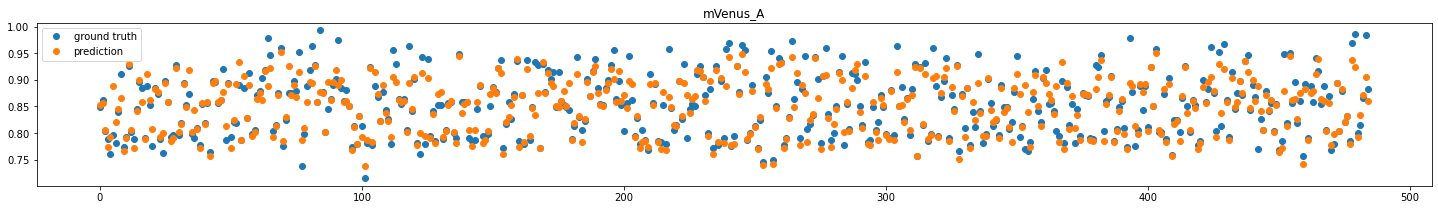

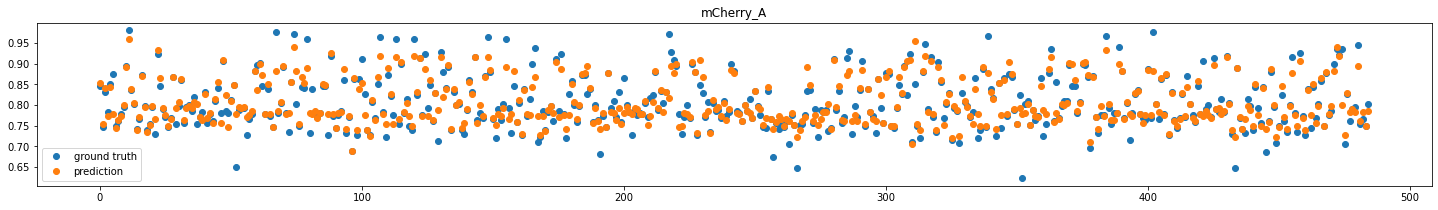

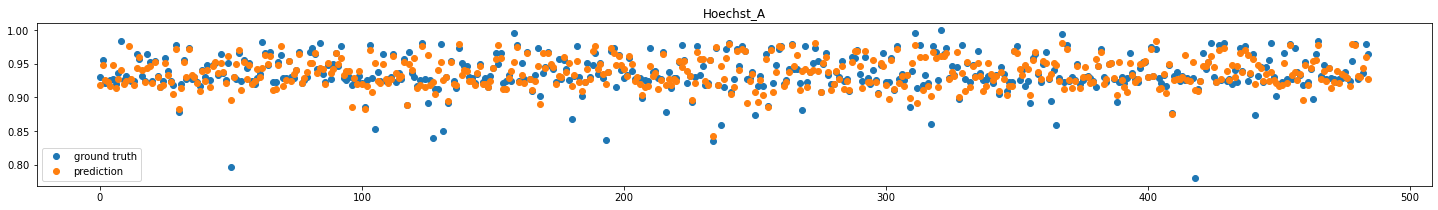

test loss=0.0017943072598427534


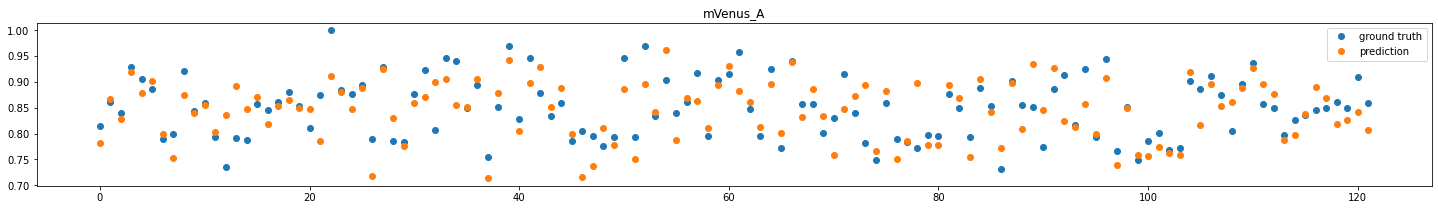

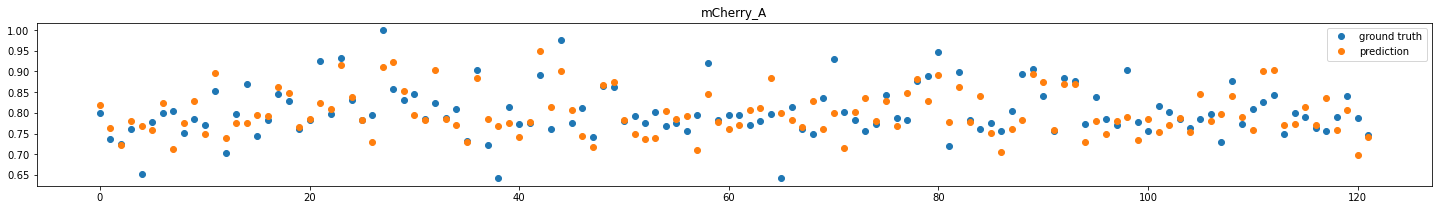

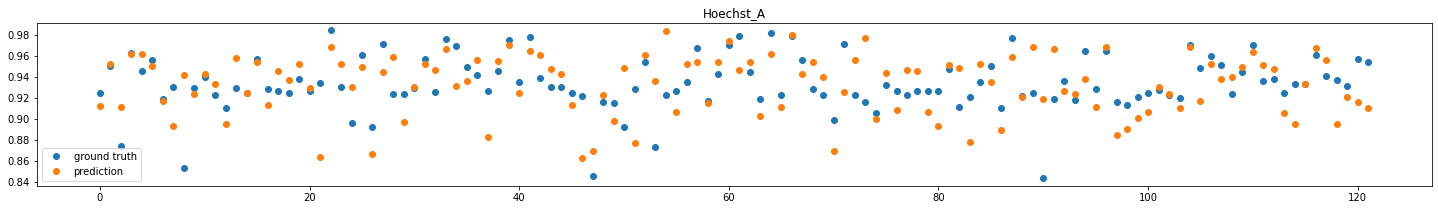

In [86]:
x, y = train_dataset[:]
x = x.to(device)
y = y.to(device)
pred = best_model(x)
y = y.cpu().detach()
pred = pred.cpu().detach()
train_loss = mse_loss(y, pred)

print('train loss={}'.format(train_loss.item()))

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(y[:, 0], 'o', label='ground truth')
plt.plot(pred[:, 0], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(y[:, 1], 'o', label='ground truth')
plt.plot(pred[:, 1], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(y[:, 2], 'o', label='ground truth')
plt.plot(pred[:, 2], 'o', label='prediction')
plt.legend()
plt.show()

x, y = test_dataset[:]
x = x.to(device)
y = y.to(device)
pred_test = best_model(x)
y = y.cpu().detach()
pred_test = pred_test.cpu().detach()
test_loss = mse_loss(y, pred_test)

print('test loss={}'.format(test_loss.item()))

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(y[:, 0], 'o', label='ground truth')
plt.plot(pred_test[:, 0], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(y[:, 1], 'o', label='ground truth')
plt.plot(pred_test[:, 1], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(y[:, 2], 'o', label='ground truth')
plt.plot(pred_test[:, 2], 'o', label='prediction')
plt.legend()
plt.show()